In [1]:
import sys, os 
current_dir = os.getcwd()
path = os.path.dirname(current_dir)
sys.path.insert(0, path)

In [2]:
from verification_diagrams import sklearn_curve_bootstrap, VerificationDiagram
from verification_diagrams import brier_skill_score
from verification_diagrams._metrics import reliability_uncertainty
from sklearn.metrics import roc_auc_score, average_precision_score

In [3]:
from sklearn.datasets import make_classification
from imblearn.datasets import make_imbalance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

## Create a Synthenic Dataset 

In [4]:
def ratio_func(y, multiplier, minority_class):
    target_stats = Counter(y)
    return {minority_class: int(multiplier * target_stats[minority_class])}

In [5]:
X, y = make_classification(10000,
    n_features=10, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1, class_sep=0.6
)

multiplier = 0.8
X_resampled, y_resampled = make_imbalance(
        X,
        y,
        sampling_strategy=ratio_func,
        **{"multiplier": multiplier, "minority_class": 1},
    )

X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.4, random_state=42
    )


lr = LogisticRegression().fit(X_train, y_train)
y_pred = lr.predict_proba(X_test)[:,1]

## Plotting a performance diagram 

For the performance diagram, we can use the `sklearn_curve_bootstrap` and set the `metric = performance`. If you we want to incorporate bootstrapping for confidence intervals, set the `n_boot` to a value greater than 1. Lastly, we can compute scalar scores (also bootstrapped) by using the `scorers` arg. In this example, we are computing the AUPDC, AUC, and BSS. 

In [6]:
xx, yy, scores = sklearn_curve_bootstrap(y_test, y_pred, metric='performance', 
                                         n_boot=10, groups=None, 
                                         scorers={'AUPDC' : average_precision_score,
                                                  'AUC' : roc_auc_score, 
                                                  'BSS' : brier_skill_score,
                                                 }, 
                            random_seed=42)

Below is a simple plot of the POD and SR for the performance diagram. If we want the additional details typically shown on a performance diagram, we can use the built plotting code in `verification_diagrams`.

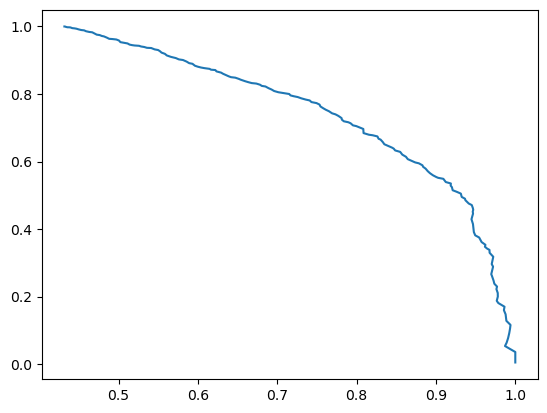

In [8]:
fig, ax = plt.subplots()
ax.plot(xx.mean(axis=0), yy.mean(axis=0))

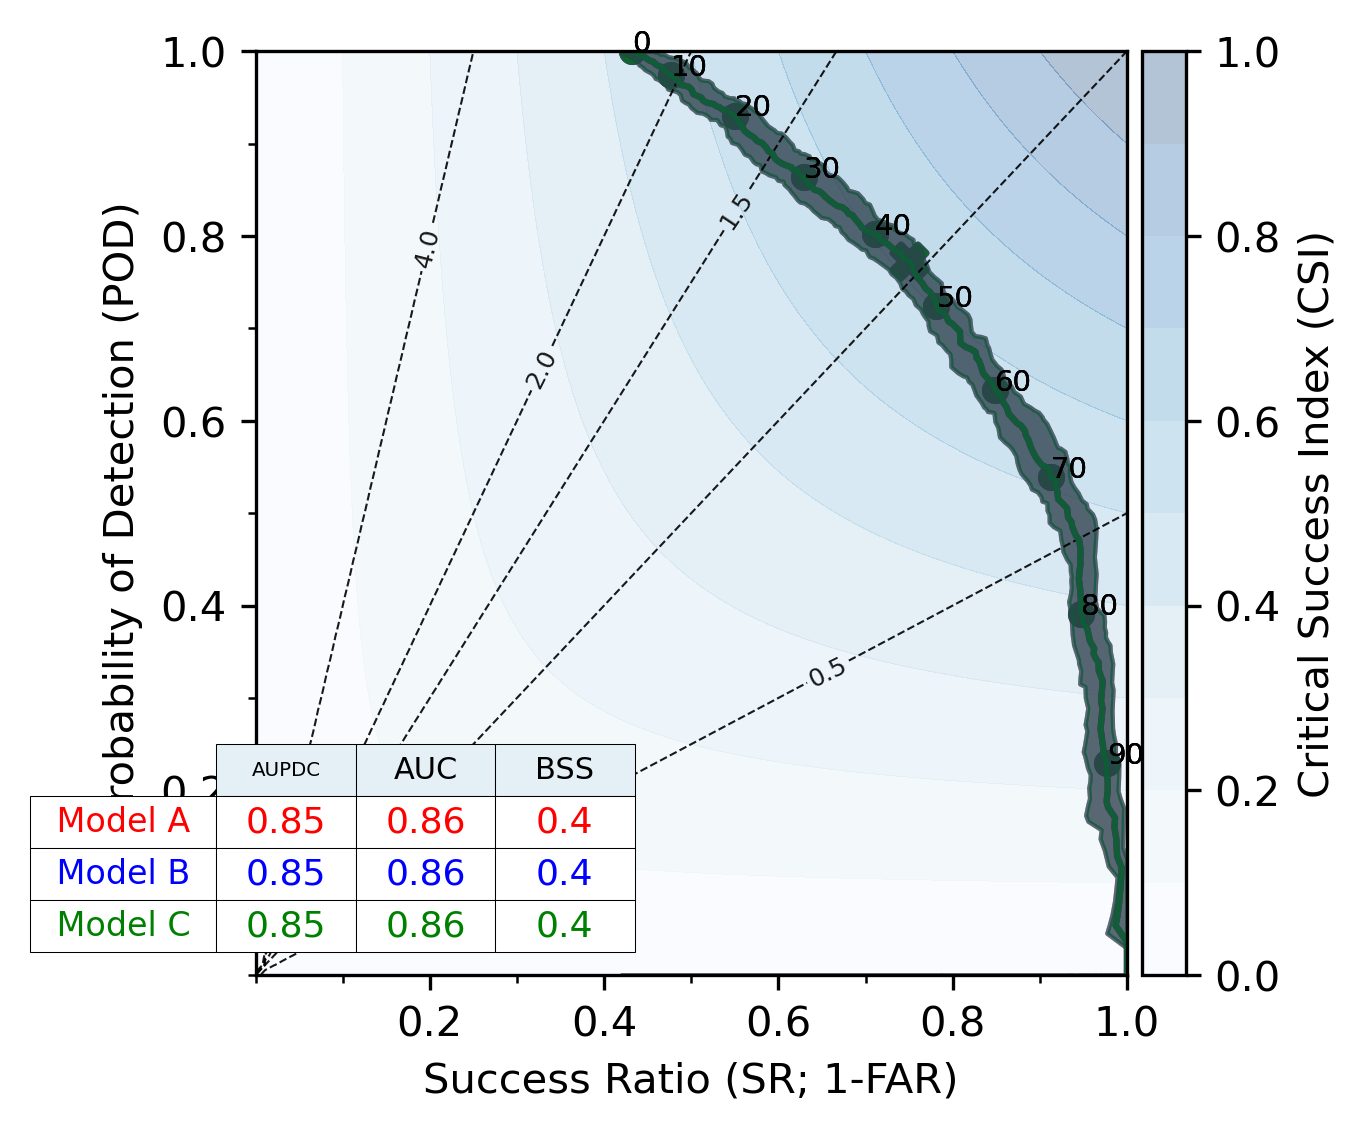

In [9]:
vd = VerificationDiagram()

scores = {'Model A' : scores, 'Model B' : scores, 'Model C' : scores}
_xx = {'Model A' : xx, 'Model B' : xx, 'Model C' : xx}
_yy = {'Model A' : yy, 'Model B' : yy, 'Model C' : yy}

ax = vd.plot('performance', _xx, _yy, scores=scores,  add_dots=True, add_max_marker=True)

### Multiple Performance Diagrams 

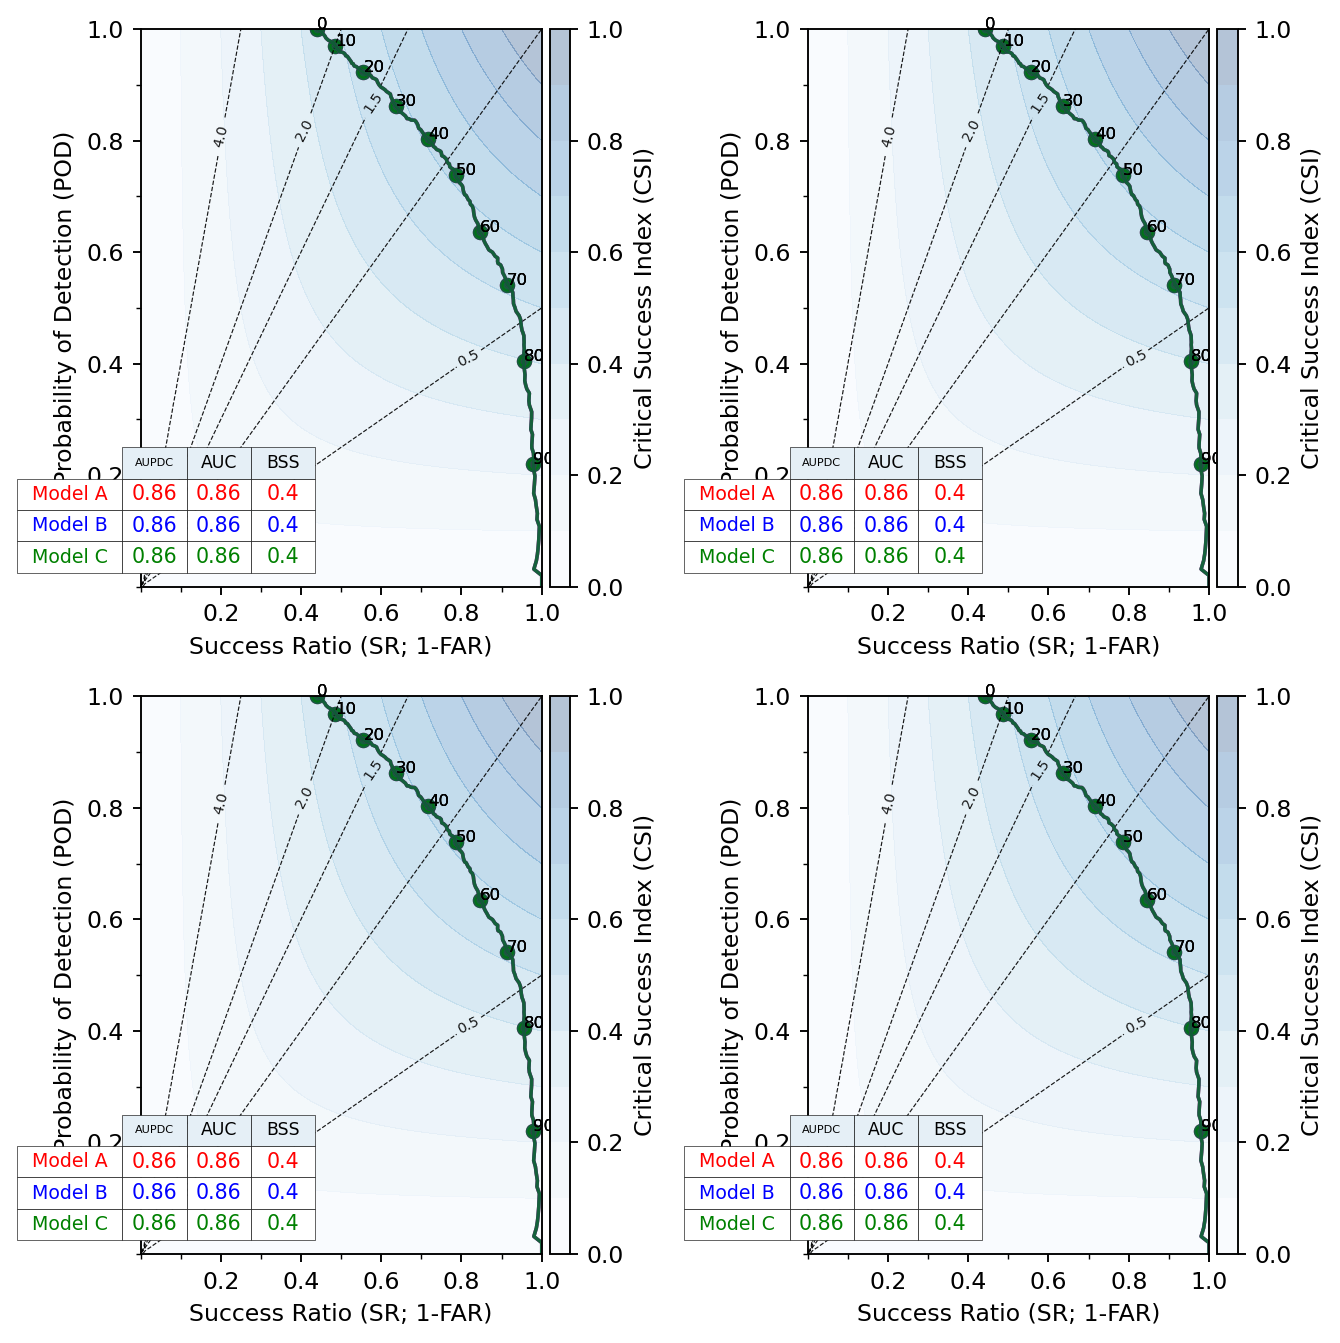

In [8]:
vd = VerificationDiagram()
fig, axes = plt.subplots(dpi=170, nrows=2, ncols=2, figsize=(8,8))
for ax in axes.flat:
    vd.plot('performance', _xx, _yy, ax=ax, scores=scores)
fig.tight_layout()

### ROC Diagram

<AxesSubplot:>

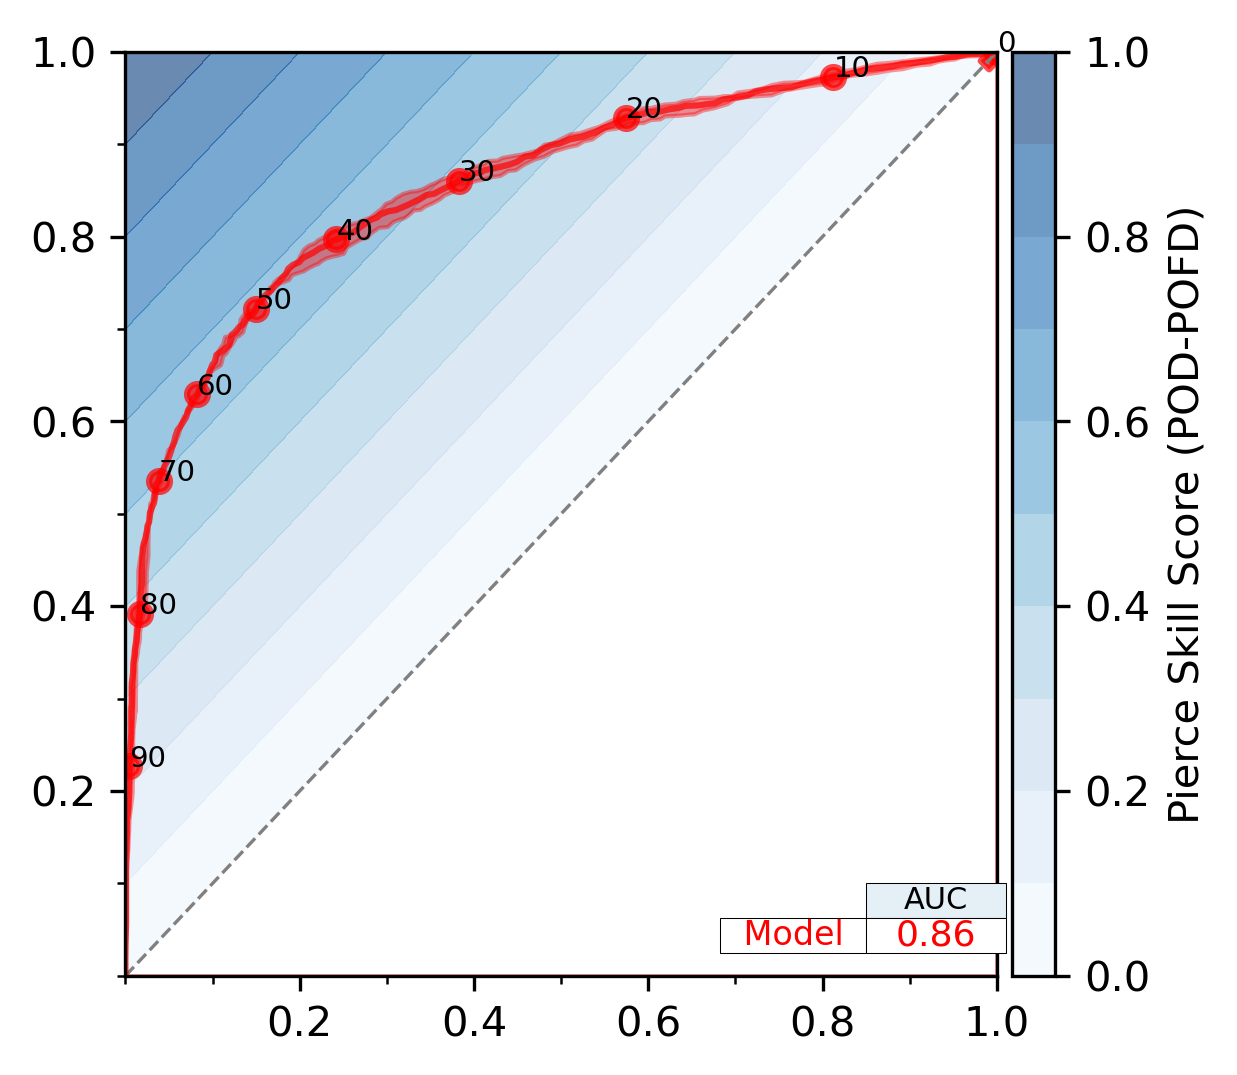

In [10]:
vd = VerificationDiagram()
xx, yy, scores = sklearn_curve_bootstrap(y_test, y_pred, metric='roc', 
                                         n_boot=30, groups=None, scorers=None, 
                            random_seed=42)

vd.plot('roc', xx, yy, scores=scores, add_dots=True, add_max_marker=True)

### Reliability Diagram 

To-Do list
* Re-think the inset figure. Often too small to be useful. Like the idea of having the graphic in the background
* Add the uncertainty bars 
* Add Legend 

Have the VerificationDiagram take y_true and y_pred as args. 

/home/monte.flora/python_packages/verification_diagrams/verification_diagrams/_diagrams.py:101: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.histplot(data, x='value', hue='variable', palette=line_colors,
/work/mflora/miniconda3/envs/wofs_post/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/work/mflora/miniconda3/envs/wofs_post/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


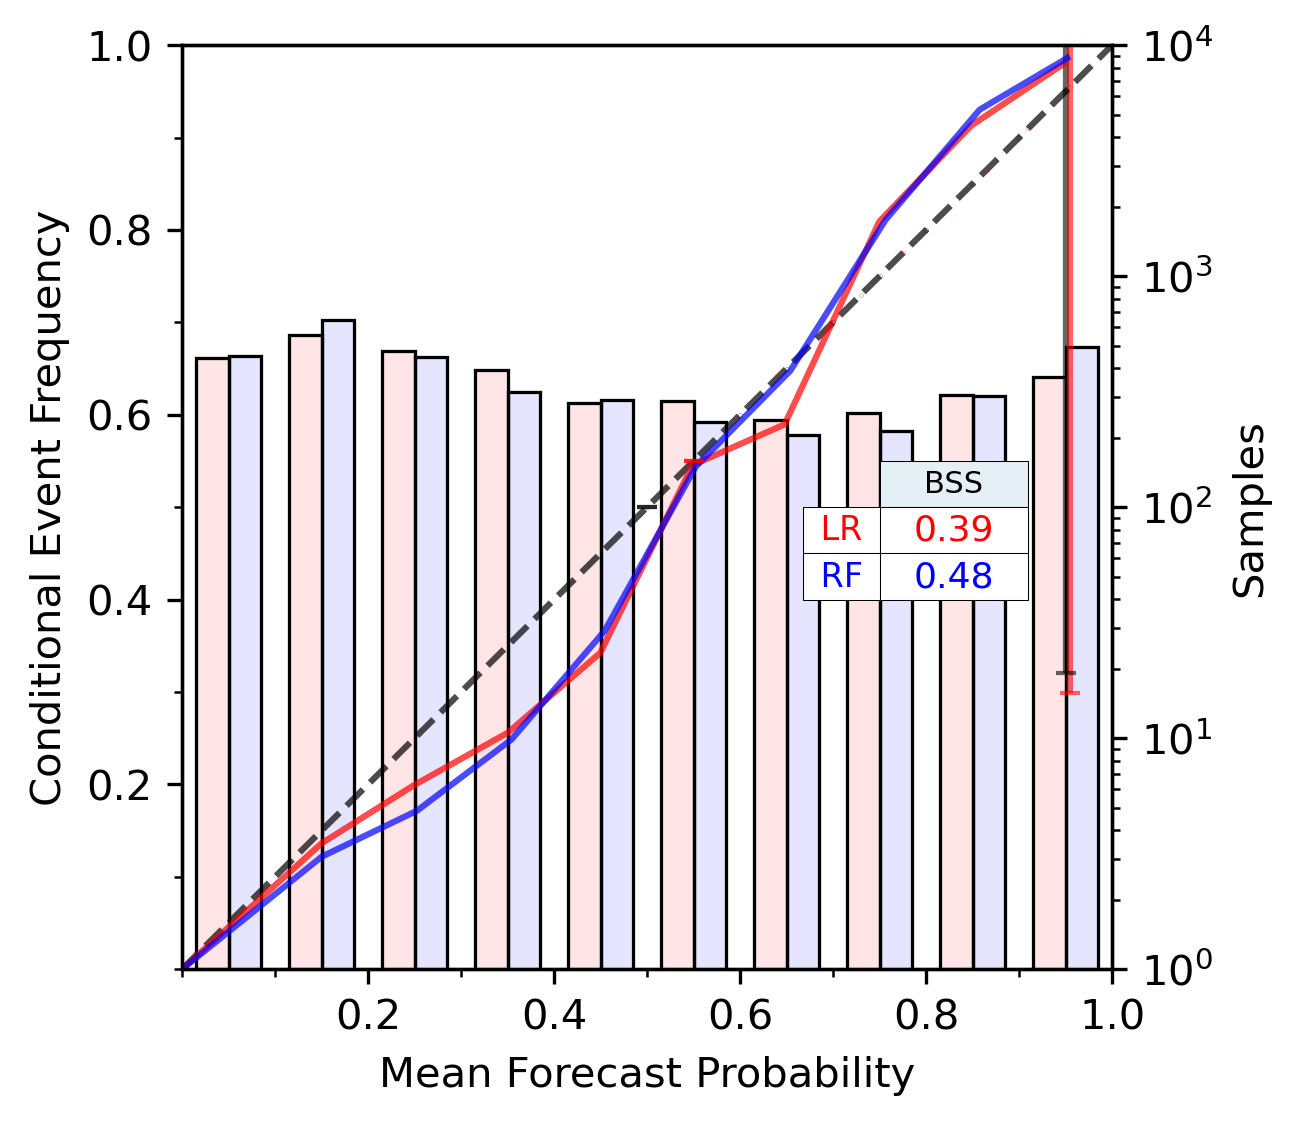

In [10]:
colors =['k', 'r', 'b']
models = [LogisticRegression(), RandomForestClassifier(), ]
names = ['LR', 'RF']
x = {}
y = {}
y_pred = {}
scores={}

for c, model, name in zip(colors, models, names):
    clf = model.fit(X_train, y_train)
    y_pred[name] = clf.predict_proba(X_test)[:,1]
    xx, yy, _scores = sklearn_curve_bootstrap(y_test, y_pred[name], metric='reliability', 
                                         n_boot=5, groups=None, scorers=None, 
                            random_seed=42)
    scores[name] = _scores
    
    x[name] = xx
    y[name] = yy
    
vd = VerificationDiagram(y_pred=y_pred)
ax = vd.plot('reliability', x, y, line_colors=colors, scores=scores, 
             table_bbox=[0.75, 0.4, 0.16*1, 0.075*2] )


d=0.05
for i, (name, color) in enumerate(zip(names, colors)):
    _, _, ef_low, ef_up = reliability_uncertainty(y_test, y_pred[name])

    x = np.linspace(0.5+(d*i),1,len(ef_low))
    
    ax.errorbar(x,x,yerr=[ef_low, ef_up], capsize=2.5, 
                fmt="o", ms=0.1, color=color, alpha=0.6)
